<a href="https://colab.research.google.com/github/prithwis/AGI/blob/main/TaxiV37_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)<br>


![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/YantraJaalBanner.png)<br>




[Prithwis Mukerjee](http://www.linkedin.com/in/prithwis)<br>

#7 x7 Trained Taxi Movements
for simulating Reinforcement Learning Applications

In [1]:
# 1. Update package list and install the NEW opengl names
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb ffmpeg freeglut3-dev python3-opengl libgl1-mesa-dev libglu1-mesa-dev mesa-utils > /dev/null 2>&1

# 2. Install the system dependencies (SWIG is the key here)
#!apt-get update
!apt-get install -y swig build-essential python3-dev > /dev/null 2>&1

# 3. Upgrade pip and setuptools to handle the build process better
!pip install --upgrade pip setuptools wheel > /dev/null 2>&1

# 4. Now install gymnasium with box2d support
#!pip install "gymnasium[box2d]" > /dev/null 2>&1

# 5. Install the Python libraries
!pip install pyvirtualdisplay  pygame opencv-python > /dev/null 2>&1


In [2]:
import pygame
import cv2
import numpy as np
import os

from IPython.display import Video, display


pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [28]:
import cv2
import numpy as np
import os

class VideoRecorder:
    def __init__(self, filename='simulation.avi', width=400, height=400, fps=15):
        self.filename = filename
        self.width = width
        # Add 60 pixels to the height for the dedicated dashboard area
        self.dash_height = 60
        self.total_height = height + self.dash_height
        self.fps = fps
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.video_writer = None

    def start(self):
        if os.path.exists(self.filename):
            os.remove(self.filename)
        # Crucial: The dimensions here MUST match the frames we write later
        self.video_writer = cv2.VideoWriter(
            self.filename, self.fourcc, self.fps, (self.width, self.total_height)
        )

    def record_frame_with_hud(self, frame_array, reward, step):
        # 1. Prepare the environment frame (the 7x7 grid)
        view = cv2.resize(frame_array, (self.width, self.total_height - self.dash_height))
        # Ensure it is in BGR for OpenCV
        #if len(view.shape) == 3 and view.shape[2] == 3:
        #    view = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        # 2. Create the light-colored Dashboard (the background for text)
        # BGR (240, 240, 240) is a nice light gray
        dashboard = np.full((self.dash_height, self.width, 3), 240, dtype=np.uint8)

        # 3. Add SMALLER, DARKER text to the dashboard
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.45  # Small and crisp
        thickness = 1
        text_color = (60, 60, 60) # Dark Gray

        cv2.putText(dashboard, f"STEP: {step}", (15, 20),
                    font, font_scale, text_color, thickness, cv2.LINE_AA)
        cv2.putText(dashboard, f"CUMULATIVE REWARD: {reward}", (15, 45),
                    font, font_scale, text_color, thickness, cv2.LINE_AA)

        # 4. Stack them: Dashboard on TOP, Environment on BOTTOM
        combined_frame = np.vstack((dashboard, view))

        # 5. Write to file
        self.video_writer.write(combined_frame)

    def stop(self):
        if self.video_writer:
            self.video_writer.release()

        output_mp4 = self.filename.replace('.avi', '.mp4')
        # Final conversion for browser compatibility
        os.system(f"ffmpeg -y -i {self.filename} -c:v libx264 -pix_fmt yuv420p {output_mp4} -hide_banner -loglevel error")
        return output_mp4

Key Features of this 7x7 World:
Logical Encoding: The state is a single integer, solving the "inhomogeneous" error permanently.

Visual Destination: In render(), I added a black outline around the target station so you can see where the taxi should be going.

Action Feedback: The taxi turns Gold (Orange) when the passenger is inside.

In [24]:
import numpy as np
import cv2

class MarsTaxi7x7:
    def __init__(self):
        self.rows = 7
        self.cols = 7
        # Stations: Red, Green, Yellow, Blue
        self.locs = [(0, 0), (0, 6), (6, 0), (6, 6)]

        # THE WALLS: Define specific blocks the taxi cannot pass through
        self.walls = [
            (1, 2), (2, 2), (3, 2), # Wall 1
            (3, 4), (4, 4), (5, 4), # Wall 2
            (3, 3)                  # Central pillar
        ]
        self.reset()

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        i = taxi_row
        i *= 7
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def reset(self):
        # Randomly assign positions
        self.taxi_row = np.random.randint(0, 7)
        self.taxi_col = np.random.randint(0, 7)

        # Ensure taxi doesn't spawn inside a wall
        while (self.taxi_row, self.taxi_col) in self.walls:
            self.taxi_row = np.random.randint(0, 7)
            self.taxi_col = np.random.randint(0, 7)

        self.pass_loc = np.random.randint(0, 5)  # 0-3: at station, 4: in taxi
        self.dest_idx = np.random.randint(0, 4)  # 0-3: destination station

        # Ensure passenger isn't already at the destination
        while self.pass_loc == self.dest_idx:
            self.dest_idx = np.random.randint(0, 4)

        return self.encode(self.taxi_row, self.taxi_col, self.pass_loc, self.dest_idx)

    def step(self, action):
        reward = -1
        terminated = False
        prev_row, prev_col = self.taxi_row, self.taxi_col

        # Movement logic
        if action == 0: self.taxi_row = min(self.rows - 1, self.taxi_row + 1) # South
        elif action == 1: self.taxi_row = max(0, self.taxi_row - 1)           # North
        elif action == 2: self.taxi_col = min(self.cols - 1, self.taxi_col + 1) # East
        elif action == 3: self.taxi_col = max(0, self.taxi_col - 1)           # West

        # Wall Collision Logic
        if (self.taxi_row, self.taxi_col) in self.walls:
            self.taxi_row, self.taxi_col = prev_row, prev_col
            reward = -5  # Penalty for hitting a wall

        elif action == 4: # Pickup
            if self.pass_loc < 4 and (self.taxi_row, self.taxi_col) == self.locs[self.pass_loc]:
                self.pass_loc = 4
                reward = 10
            else:
                reward = -10

        elif action == 5: # Dropoff
            if self.pass_loc == 4 and (self.taxi_row, self.taxi_col) == self.locs[self.dest_idx]:
                reward = 20
                terminated = True
            else:
                reward = -10

        new_state = self.encode(self.taxi_row, self.taxi_col, self.pass_loc, self.dest_idx)
        return new_state, reward, terminated

    def render(self):
        img = np.full((400, 400, 3), 255, dtype=np.uint8)
        cell_size = 400 // 7

        # Draw the Grid Lines
        for i in range(8):
            cv2.line(img, (0, i * cell_size), (400, i * cell_size), (200, 200, 200), 1)
            cv2.line(img, (i * cell_size, 0), (i * cell_size, 400), (200, 200, 200), 1)

        # Draw the Walls (Dark Grey)
        for (r, c) in self.walls:
            cv2.rectangle(img, (c*cell_size, r*cell_size), ((c+1)*cell_size, (r+1)*cell_size), (80, 80, 80), -1)

        # Draw Stations
        station_colors = [(0,0,255), (0,255,0), (0,255,255), (255,0,0)] # BGR
        for i, (r, c) in enumerate(self.locs):
            cv2.rectangle(img, (c*cell_size+5, r*cell_size+5), ((c+1)*cell_size-5, (r+1)*cell_size-5), station_colors[i], -1)

        # Destination Marker
        dr, dc = self.locs[self.dest_idx]
        cv2.rectangle(img, (dc*cell_size+2, dr*cell_size+2), ((dc+1)*cell_size-2, (dr+1)*cell_size-2), (0, 0, 0), 2)

        # Draw the Taxi
        #tx, ty = self.taxi_col * cell_size + cell_size//2, self.taxi_row * cell_size + cell_size//2
        #taxi_color = (0, 165, 255) if self.pass_loc == 4 else (0, 0, 0)
        #cv2.circle(img, (tx, ty), 15, taxi_color, -1)

        # 4. Draw the Taxi
        # Calculate center position
        tx = self.taxi_col * cell_size + cell_size // 2
        ty = self.taxi_row * cell_size + cell_size // 2

        # --- THE COLOR LOGIC ---
        if self.pass_loc == 4:
            # OCCUPIED: Bright Gold/Yellow (BGR: 0, 215, 255)
            taxi_color = (0, 215, 255)
            label = "BUSY"
        else:
            # VACANT: Deep Black or Gray (BGR: 0, 0, 0)
            taxi_color = (0, 0, 0)
            label = "EMPTY"

        # Draw the main taxi body
        cv2.circle(img, (tx, ty), 15, taxi_color, -1)

        return img

Why these settings matter:
The State Count: We are using exactly 980 rows. If the taxi wanders into a state it hasn't seen before, it will have a row of zeros. 20,000 episodes is usually enough to "visit" most relevant paths.

Gamma (0.9): This tells the taxi that getting the passenger eventually is worth a lot, even if the individual steps give -1 reward.

Epsilon Decay: We want the taxi to be random for a long time. In a 7x7 world, the probability of randomly hitting the "Pickup" action at exactly the right coordinate is lower than in a 5x5 world.

In [5]:
import numpy as np
import random

# 1. Initialize Environment and Brain
env = MarsTaxi7x7()
q_table = np.zeros([980, 6]) # 980 states, 6 actions

# 2. Hyperparameters
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor (priority on future rewards)
epsilon = 1.0        # Start 100% random
epsilon_decay = 0.00005 # Slow decay for a larger map
min_epsilon = 0.1
episodes = 40000

print("Training started...")

# 3. Training Loop
for episode in range(episodes):
    state = env.reset()
    terminated = False

    while not terminated:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 5) # Explore
        else:
            action = np.argmax(q_table[state]) # Exploit

        next_state, reward, terminated = env.step(action)

        # Q-Table Update Math
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # New Q-Value formula
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = next_state

    # Decrease randomness over time
    if epsilon > min_epsilon:
        epsilon -= epsilon_decay

    # Progress report every 2000 episodes
    if (episode + 1) % 2000 == 0:
        print(f"Episode {episode + 1}/{episodes} | Current Epsilon: {epsilon:.2f}")

print("Training Complete! The Q-Table is now ready for a test flight.")

Training started...
Episode 2000/40000 | Current Epsilon: 0.90
Episode 4000/40000 | Current Epsilon: 0.80
Episode 6000/40000 | Current Epsilon: 0.70
Episode 8000/40000 | Current Epsilon: 0.60
Episode 10000/40000 | Current Epsilon: 0.50
Episode 12000/40000 | Current Epsilon: 0.40
Episode 14000/40000 | Current Epsilon: 0.30
Episode 16000/40000 | Current Epsilon: 0.20
Episode 18000/40000 | Current Epsilon: 0.10
Episode 20000/40000 | Current Epsilon: 0.10
Episode 22000/40000 | Current Epsilon: 0.10
Episode 24000/40000 | Current Epsilon: 0.10
Episode 26000/40000 | Current Epsilon: 0.10
Episode 28000/40000 | Current Epsilon: 0.10
Episode 30000/40000 | Current Epsilon: 0.10
Episode 32000/40000 | Current Epsilon: 0.10
Episode 34000/40000 | Current Epsilon: 0.10
Episode 36000/40000 | Current Epsilon: 0.10
Episode 38000/40000 | Current Epsilon: 0.10
Episode 40000/40000 | Current Epsilon: 0.10
Training Complete! The Q-Table is now ready for a test flight.


In [ ]:
#q_table = np.zeros([980, 6]) # 980 states, 6 actions

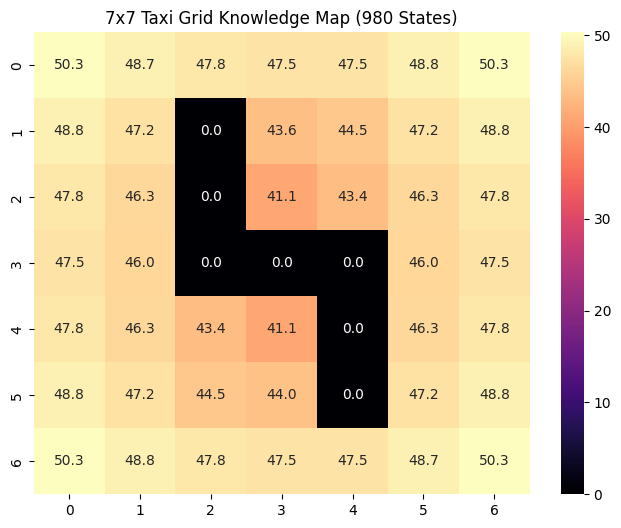

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Since you have 980 states, we assume a 7x7 grid
# 980 / (5 passenger locs * 4 destinations) = 49 squares
grid_size = 7
max_q = np.max(q_table, axis=1)

# Initialize a 7x7 grid
grid_view = np.zeros((grid_size, grid_size))
counts = np.zeros((grid_size, grid_size))

for state in range(len(max_q)):
    # Decoding for a 7x7 grid (980 states)
    # Each 'block' of 20 states belongs to one square (5 pass * 4 dest)
    square_index = state // 20

    row = square_index // grid_size
    col = square_index % grid_size

    grid_view[row, col] += max_q[state]
    counts[row, col] += 1

# Average the values
average_grid = grid_view / counts

plt.figure(figsize=(8, 6))
sns.heatmap(average_grid, annot=True, fmt=".1f", cmap="magma")
plt.title("7x7 Taxi Grid Knowledge Map (980 States)")
plt.show()

In [21]:
import os

# 1. Setup Environment and Recorder
env = MarsTaxi7x7()
# We use a lower FPS (e.g., 5 or 10) so the moves are easy to follow
recorder = VideoRecorder(filename='final_mars_mission.avi', width=640, height=480, fps=2)
recorder.start()

state = env.reset()
done = False
total_reward = 0
step_count = 0

print("🎥 Recording the trained agent's performance...")

# 2. The Simulation Loop (Strictly Exploitation)
while not done and step_count < 100:
    # Capture current visual frame
    frame_array = env.render()

    # Record frame with HUD (Reward and Step count)
    recorder.record_frame_with_hud(frame_array, total_reward, step_count)

    # Choose action: Use np.argmax (No more randomness!)
    action = np.argmax(q_table[state])

    # Execute step in your 7x7 custom env
    state, reward, done = env.step(action)

    total_reward += reward
    step_count += 1

# 3. Save and Finalize
video_mp4 = recorder.stop()

if done:
    print(f"✨ Mission Accomplished in {step_count} steps!")
else:
    print("⚠️ Mission timed out. The agent might need more training or a higher step limit.")

print(f"💾 Video ready: {video_mp4}")

🎥 Recording the trained agent's performance...
✨ Mission Accomplished in 10 steps!
💾 Video ready: final_mars_mission.mp4


In [22]:
import numpy as np

def run_trained_mars_taxi(q_table, num_trips=5):
    # 1. Initialize your custom 7x7 environment and recorder
    env = MarsTaxi7x7()
    # 400x400 matches your render output size
    recorder = VideoRecorder(filename='mars_taxi_master.avi', width=400, height=400, fps=5)
    recorder.start()

    print(f"🚀 Starting {num_trips} trips to Mars...")

    total_steps_in_video = 0

    for trip in range(num_trips):
        state = env.reset()
        terminated = False
        trip_reward = 0

        # Limit each trip to 100 steps to prevent infinite loops if the agent gets stuck
        trip_steps = 0

        while not terminated and trip_steps < 100:
            # 1. Action selection from your 980-state Q-table
            action = np.argmax(q_table[state])

            # 2. Your custom 3-value step return
            state, reward, terminated = env.step(action)
            trip_reward += reward

            # 3. Capture and Record Frame
            # Your render() returns the 400x400 image array
            frame = env.render()
            recorder.record_frame_with_hud(frame, trip_reward, trip_steps)

            total_steps_in_video += 1
            trip_steps += 1

        if terminated:
            print(f"Trip {trip+1}: Goal reached! Reward: {trip_reward}")
        else:
            print(f"Trip {trip+1}: Timed out.")

    # 4. Stop, Convert, and Display
    final_file = recorder.stop()
    print(f"🎬 Video complete: {final_file}")

    # If in Jupyter/Colab
    from IPython.display import Video, display
    display(Video(final_file, embed=True))



In [29]:
# Execute the test flight
run_trained_mars_taxi(q_table, num_trips=20)

🚀 Starting 20 trips to Mars...
Trip 1: Goal reached! Reward: 8
Trip 2: Goal reached! Reward: 20
Trip 3: Goal reached! Reward: 18
Trip 4: Goal reached! Reward: 8
Trip 5: Goal reached! Reward: 9
Trip 6: Goal reached! Reward: 10
Trip 7: Goal reached! Reward: 16
Trip 8: Goal reached! Reward: 19
Trip 9: Goal reached! Reward: 23
Trip 10: Goal reached! Reward: 13
Trip 11: Goal reached! Reward: 11
Trip 12: Goal reached! Reward: 14
Trip 13: Goal reached! Reward: 19
Trip 14: Goal reached! Reward: 14
Trip 15: Goal reached! Reward: 19
Trip 16: Goal reached! Reward: 23
Trip 17: Goal reached! Reward: 19
Trip 18: Goal reached! Reward: 20
Trip 19: Goal reached! Reward: 8
Trip 20: Goal reached! Reward: 22
🎬 Video complete: mars_taxi_master.mp4


#Chronobooks <br>
Three science fiction novels by Prithwis Mukerjee. A dystopian Earth. A technocratic society managed by artificial intelligence. Escape and epiphany on Mars. Can man and machine, carbon and silicon explore and escape into other dimensions of existence? An Indic perspective rooted in Advaita Vedanta and the Divine Feminine.  [More information](http://bit.ly/chrono3) <br>
![alt text](https://blogger.googleusercontent.com/img/a/AVvXsEjsZufX_KYaLwAnJP6bUxvDg5RSPn6r8HIZe749nLWX3RuwyshrYEAUpdw03a9WIWRdnzA9epwJOE05eDJ0Ad7kGyfWiUrC2vNuOskb2jA-e8aOZSx8YqzT8mfZi3E4X1Rz3qlEAiv-aTxlCM976BEeTjx4J64ctY3C_FoV4v9aY_U23F8xRqI5Eg=s1600)